In [1]:
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from scipy import stats
from scipy.stats import norm
%matplotlib inline

In [2]:
df = pd.read_pickle('gpData.pkl')
NrSbj = len(df.sbjId.unique())
#sns.distplot(df.loc[~np.isnan(df.sbjRT),'sbjRT'])
print('A total of ' + str(NrSbj) + ' subjects')
df.loc[df.sbjRT<250, 'sbjRT']  = np.nan
df.loc[df.sbjRT<250, 'sbjACC'] = 0
df.loc[df.sbjRT>1500, 'sbjRT']  = np.nan
df.loc[df.sbjRT>1500, 'sbjACC'] = 0
# stimulus duration was set to be 1500 ms. subj must respond within this deadline

A total of 52 subjects


In [3]:
#%% do a fist pass to exclude subjects with low cued task accuracy
goodSbj=[]
excludeSbj=[]
for S in np.unique(df.sbjId):
    D = df.loc[df.sbjId==S] 
    overallCuedTSACC = D[D.trialType=='cued'].sbjACC.mean()*100
    trainingTSACC = D[D.phase=='training'].sbjACC.mean()*100
    overallVTS = D[D.trialType=='choice'].trialType_int.mean()*100
    if  (overallCuedTSACC >= 80) & ( trainingTSACC >= 0) & (overallVTS >= 10):  # & (D.sbjACC.mean()*100>60):
        goodSbj.append(S)
    else:
        excludeSbj.append(S)
df_valid = pd.DataFrame(np.empty((0,0),dtype=int))
for S in goodSbj:
    df_valid = pd.concat([df_valid, df[df.sbjId==S]],axis=0)
df_valid.reset_index(inplace=True)
validSCNT = len(df_valid.sbjId.unique())
print('After excluding subjects with poor performance: A total of ' + str(validSCNT) + ' subjects')

After excluding subjects with poor performance: A total of 38 subjects


In [4]:
df2 = df_valid.loc[df_valid.phase=='training',:] # 256 trials/S x 38S

In [5]:
for S in df2.sbjId.unique():    
    for stim in [1,2,3,4,5,6,7,8]:
        df2.loc[(df2.sbjId==S) & (df2.stimUnique==stim),'repetition'] = np.linspace( 1, 32, 32 )  

C:\Users\yc180\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\yc180\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
df3 = df2.loc[df2.repetition<=12,:] 
# repeat X times for each stim
len(df3)/len(df3.sbjId.unique())/8

12.0

------Group mean RT--------
swProb  trialType_sw
sw25%   repeat          801.728116
        switch          911.530177
sw75%   repeat          812.416213
        switch          878.037141
Name: sbjRT, dtype: float64


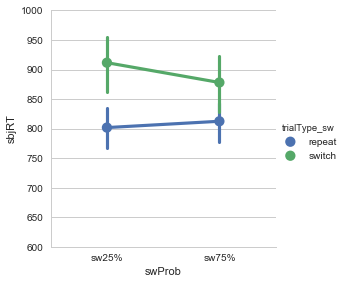

In [7]:
condM_rt = df3.loc[df3.sbjACC==1,:].groupby(['sbjId','swProb','trialType_sw']).sbjRT.mean().reset_index()
# a dataframe of subject x condition 
g= sns.factorplot(x='swProb',y='sbjRT', hue='trialType_sw',data=condM_rt)
g.set(ylim=(600, 1000))
# Group Mean
gpResult_ts_rt  = condM_rt.groupby(['swProb','trialType_sw']).sbjRT.mean()
print('------Group mean RT--------')
print(gpResult_ts_rt)

In [8]:
len(condM_rt.sbjId.unique())

38

In [9]:
for S in condM_rt.sbjId.unique():
    D = condM_rt.loc[condM_rt.sbjId==S,:]
    if (sum(np.isnan(D.sbjRT))>0) | (len(D.sbjRT)<4):
        condM_rt.drop(condM_rt.loc[condM_rt.sbjId==S].index,inplace=True)
len(condM_rt.sbjId.unique())

38

In [10]:
rt1 = np.array(condM_rt.loc[(condM_rt.swProb=='sw25%') & (condM_rt.trialType_sw=='switch'),'sbjRT'])
rt2 = np.array(condM_rt.loc[(condM_rt.swProb=='sw25%') & (condM_rt.trialType_sw=='repeat'),'sbjRT'])
rt3 = np.array(condM_rt.loc[(condM_rt.swProb=='sw75%') & (condM_rt.trialType_sw=='switch'),'sbjRT'])
rt4 = np.array(condM_rt.loc[(condM_rt.swProb=='sw75%') & (condM_rt.trialType_sw=='repeat'),'sbjRT'])
ISSP = rt1-rt2-(rt3-rt4)
print('meanISSP = ' + '{:.2f}'.format(ISSP.mean()) + ' ms')
simple_inX_test = stats.ttest_rel(rt1-rt2,rt3-rt4)
print(simple_inX_test.pvalue)

meanISSP = 44.18 ms
0.0138246160123
